# CNN

In [1]:
import torch
from torch import nn
import dl2_torch as d2l

from torch.nn import functional as F

d:\Anaconda3\envs\data_torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 基本概念

1. 判断模型是否会过拟合，查看模型参数容量与数据量的大小，如果参数大于数据量，则每个参数都记住一个数据就行了。

2. 原始式子就是普通的 2 维输出到 2 维输出的MLP，利用平移不变性使模式与输出图片的像素位置i，j无关，利用局部性使a，b只关注在小范围内。
<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202408081001835.png" width='500px' >
</div>

2. 卷积与数学卷积概念相似，只是一种离散化的卷积计算方式。  如下是严格的卷积操作公式，其中f表示卷积核，g表示输入：
$$ (f * g)(i, j) = \sum_a\sum_b f(a, b) g(i-a, j-b) $$  
CNN的卷积层实际上互相关计算，因为g是将i - a 元素与a相乘，如果要表示严格的卷积操作，需要将卷积核在垂直及水平方向上进行翻转（或者说卷积层中学得的kernel需要翻转后才是上面式子中的f），不过不影响训练及推理应用。

3. 输出尺寸快速计算公式:
$$ \lfloor(n_\textrm{h}-k_\textrm{h}+p_\textrm{h}+s_\textrm{h})/s_\textrm{h}\rfloor \times \lfloor(n_\textrm{w}-k_\textrm{w}+p_\textrm{w}+s_\textrm{w})/s_\textrm{w}\rfloor。 $$  
其中 h,w 表示高宽， n表示输入，k表示核大小，padding，stride  
stride 可以为 1/2 表示反卷积(上采样)，可能出现伪影(黑白格)问题。

4. 通道数 相对 kernel_size,padding，stride 这三个超参数更加重要.

5. Padding 0 并不会影响网络性能，0与卷积核相乘后不改变输出大小，会对bias有影响但不重要。

### 1. 单维度卷积实现方式

改变矩阵形状后通过矩阵乘法实现

In [2]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    # Matrix multiplication in the fully connected layer
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))

没有非线性的连续卷积操作可以等效为当个卷积操作，该卷积的尺寸为这两单卷积尺寸的和-1。  
**那么单一卷积是否总能分解为两个卷积？ ** 

### 2. 池化

具有双重目的，一是减轻卷积层对位置的敏感性，二是空间下采样表示  
池化层的目的是为了找到最大的特征数值，因此其后面无需添加非线性操作。  


max(a,b) = ReLU(a−b)+b

### 3. 网络打印
打印网络每层输出的shape, 可以推广至别的框架

In [ ]:
@d2l.add_to_class(d2l.Classifier)  #@save
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()
model.layer_summary((1, 1, 28, 28))

计算复杂度，CPU（0.15TF）及GPU（12TF）预算时间估计：  
<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202408091950639.png" width='500px' >
</div>

现代硬件设备区别：
https://d2l.ai/chapter_convolutional-modern/alexnet.html

### 4. 图片输入尺寸的改变方式  
将图片的短边变为模型的输入要求尺寸，长边保持长宽比相应调整，然后从图片中按照长度方向切图片出来做预测。  
**不要直接resize**

### Batch Normalization

<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202411252132727.png" width='500px' >
</div>

以 tanh 激活函数为例， 原始输入为均匀分布，由于中间激活函数的作用，导致越往深层分布越加不均匀，因此需要 normalization  
梯度消失的原因  
神经网络在训练过程中，随着深度加深，输入值分布会发生偏移，向取值区间上下两端靠近，如Sigmoid，Tanh函数，就会导致反向传播时低层神经网络的梯度消失，这是深层网络收敛越来越慢的重要原因

IID 独立同分布假设  
假设训练数据和测试数据是满足相同分布。  
独立同分布假设是通过训练集得到的模型在测试集能有好效果的基本保障  
源空间sourcedomain和目标空间（targetdomain）的数据分布（distribution）是一致的。

直觉： 损失出现在最后，后面的层训练较快，数据在最底部，底部的层训练较慢，底部层参数一变化，所有都得跟着变
最后的那些层需要重新学习多次，导致收敛变慢，我们可以在学习底部层的时候避免变化顶部层吗？

因此BN 适用于深层网络， 浅层效果不大。

批量标准化可能的三个优点：  
1. 对数据进行预处理；  
2. 保持数据在每个层的流动中保持数值稳定， 不会出现明显的量级变化；  
3. *正则化*： 类似数据正则化，在训练的时候由于batch的不同，每个batch的均值及方差会不同，导致存在噪声；训练完成进行推理时，使用整个数据集来计算均值及方差，这个角度看 BN 与 dropout 具有相似的行为。  

BN 不会增加模型精度，但会提高模型的收敛速度（可以使用更大的学习率）。  
在应用批量归一化时，批量大小的选择比没有批量归一化时更为重要，需要对batch size 耐心调整。

在全连接层上的数据公式定义：  
$$ \mathbf{h} = \phi(\textrm{BN}(\mathbf{W}\mathbf{x} + \mathbf{b}) )。$$  
即全连接层最开始是在 仿射变换 与 激活函数之间，后续有研究放到其他位置。  

全连接层 BN ：计算batch中所有样本的均值及方差，作为归一化的参数。  
卷积 BN： 针对每个通道计算归一化的参数，即对某个通道中的 Batch * height * width 个像素求该通道的均值方差。  
层归一化：针对单个样本，设输入 X 为 n 维向量，则公式如下：  
$$ \mathbf{x} \rightarrow \textrm{LN}(\mathbf{x}) = \frac{\mathbf{x} - \hat{\mu}}{\hat\sigma} $$ 
$$ \hat{\mu} \stackrel{\textrm{def}}{=} \frac{1}{n} \sum_{i=1}^n x_i \textrm{ ,  }
\hat{\sigma}^2 \stackrel{\textrm{def}}{=} \frac{1}{n} \sum_{i=1}^n (x_i - \hat{\mu})^2 + \epsilon$$   

使用层规范化的主要好处之一是它可以防止发散,对于任何a != 0, 均有$$ \textrm{LN}(\mathbf{x}) \approx \textrm{LN}(\alpha \mathbf{x}) $$   
层归一化的另一个优点是它不依赖于小批量大小。它也与我们是在训练还是测试阶段无关。换句话说，它只是一个确定性的转换，将激活标准化到给定的尺度。这对于防止优化中的分歧非常有益​​。  

#### 不同的归一化  
不同归一化适用场景不同  
<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202411252200957.png" width='500px' >
</div>  

在 CNN 中， BN 将一个特征图当作归一化的维度（如上图所示， 在所有样本的各个通道上进行归一化）

**作用的位置**：  
1. 在FC 即 Conv 的输出后， 激活层输出前（relu 会将输出拉到正数，再重新用BN变出负值奇怪）
2. 作用于输入上（输入就是激活输出，所以和用在激活层后貌似也没区别。）

#### BN 有效解释  
1. 并没有解决协变量转移问题， 猜测为通过小批量加入噪音来控制模型复杂度。（不需要和dropout一起使用）  
BN的有效性是实践得出的， 在CNN中应用较多， 但对于卷积层也可以考虑替换为层归一化。  
对于对输入扰动不太敏感的更稳健的模型，请考虑删除批量标准化[Wang, H., Zhang, A., Zheng, S., Shi, X., Li, M., & Wang, Z. (2022). Removing batch normalization boosts adversarial training. International Conference on Machine Learning (pp. 23433–23445).]。  

#### 手动实现BN

考虑下方实现时将计算函数 与 层结构定义隔离，类似 F 与 nn.Module。函数关注具体的数值及流程计算，moudle关注参数的绑定及梯度的计算。  
全部数据集的均值及方差通过在每个batch上的滑动平均计算

In [12]:
test = torch.range(0,15).reshape(2,2,2,2)
test.mean(dim=(0,2,3))  # 按照第二个维度算平均值， 结构的维度和dim=1的维度相同

d:\Anaconda3\envs\data_torch\lib\site-packages\ipykernel_launcher.py:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  """Entry point for launching an IPython kernel.


tensor([5.5000, 9.5000])

In [46]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # Use is_grad_enabled to determine whether we are in training mode
    if not torch.is_grad_enabled():
        # In prediction mode, use mean and variance obtained by moving average
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # When using a fully connected layer, calculate the mean and
            # variance on the feature dimension
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=1). Here we
            # need to maintain the shape of X, so that the broadcasting
            # operation can be carried out later
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # In training mode, the current mean and variance are used
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # Update the mean and variance using moving average
        moving_mean = (1.0 - momentum) * moving_mean + momentum * mean
        moving_var = (1.0 - momentum) * moving_var + momentum * var
    Y = gamma * X_hat + beta  # Scale and shift
    return Y, moving_mean.data, moving_var.data

In [47]:
class BatchNorm(nn.Module):
    # num_features: the number of outputs for a fully connected layer or the
    # number of output channels for a convolutional layer. num_dims: 2 for a
    # fully connected layer and 4 for a convolutional layer
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter (model parameters) are
        # initialized to 1 and 0, respectively
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # The variables that are not model parameters are initialized to 0 and
        # 1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # If X is not on the main memory, copy moving_mean and moving_var to
        # the device where X is located
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # Save the updated moving_mean and moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.1)
        return Y

In [48]:
class BNLeNetScratch(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5), BatchNorm(6, num_dims=4),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), BatchNorm(16, num_dims=4),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(), nn.LazyLinear(120),
            BatchNorm(120, num_dims=2), nn.Sigmoid(), nn.LazyLinear(84),
            BatchNorm(84, num_dims=2), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

KeyboardInterrupt: 

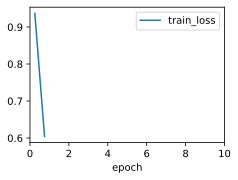

In [49]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = BNLeNetScratch(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

In [50]:
model.net[1].gamma.reshape((-1,)), model.net[1].beta.reshape((-1,))  
#  查看学得的缩放比例及便宜

(tensor([1.1486, 1.0054, 1.0713, 0.9772, 1.1868, 1.0601], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>),
 tensor([ 0.0875, -0.2514,  0.0095, -0.1670, -0.0848,  0.1692], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>))

## AlexNet（2012） 
网络结构与 LeNet 相似，原始论文中有部分现在看来没有必要的设计，调整后结构如下：  
<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202408101411287.png" width='1000px' >
</div>

In [3]:
import torch
from torch import nn
import dl2_torch as d2l

from torch.nn import functional as F


d:\Anaconda3\envs\data_torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
class AlexNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=11, stride=4, padding=1),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(4096), nn.ReLU(),nn.Dropout(p=0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

In [5]:
AlexNet().layer_summary((1, 1, 224, 224))

d:\Anaconda3\envs\data_torch\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

```python
model = AlexNet(lr=0.01)
data = d2l.FashionMNIST(batch_size=32, resize=(224, 224))
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(model, data)
```  
将上方 cpu 代码修改为 gpu 训练  
下发内容 ：  修改批量大小，观察吞吐量（图像/秒）、准确率和 GPU 内存的变化。  
**随着batch_size 提高，模型吞吐量变大，每秒处理图像增多，但是准确率下降。**

loss 0.225, train acc 0.917, test acc 0.904
866.9 examples/sec on cuda


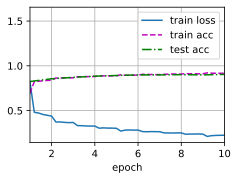

In [8]:
data = d2l.FashionMNIST(batch_size=32, resize=(224, 224))
train_dataloader, test_dataloader = data.get_dataloader(train=True), data.get_dataloader(train=False)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
d2l.train_ch6(model, train_dataloader, test_dataloader, 10, 0.01, device)

loss 0.274, train acc 0.899, test acc 0.898
905.0 examples/sec on cuda


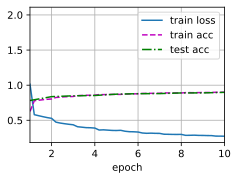

In [9]:
data = d2l.FashionMNIST(batch_size=64, resize=(224, 224))
train_dataloader, test_dataloader = data.get_dataloader(train=True), data.get_dataloader(train=False)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
d2l.train_ch6(model, train_dataloader, test_dataloader, 10, 0.01, device)

loss 0.326, train acc 0.880, test acc 0.870
987.3 examples/sec on cuda


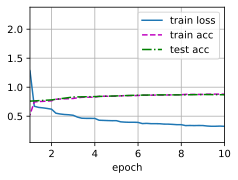

In [10]:
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
train_dataloader, test_dataloader = data.get_dataloader(train=True), data.get_dataloader(train=False)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
d2l.train_ch6(model, train_dataloader, test_dataloader, 10, 0.01, device)

1. 图中没有显示过拟合，是因为还在训练前期阶段，迭代次数多可能发生过拟合；
2. AlexNet 浮点运算需求为LeNet 200倍， 但运行时间为20倍（同在GPU上），因为AlexNet结构更加适合GPU跑并行，GPU应用率更高（nvidia-smi中）

## VGG (2014)

相比于 AlexNet 各层定制化，VGG给出了更泛化的视觉神经网络模式，即通过定义卷积块并不断堆叠相应的卷积块以实现系列网络，每个块可以通过参数实现不同的层组方式。  

VGG 与 AlexNet对比计算量  https://pandalab.me/archives/vgg

In [6]:
def vgg_block(num_convs, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

In [7]:
class VGG(d2l.Classifier):
    def __init__(self, arch, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        conv_blks = []
        for (num_convs, out_channels) in arch:
            conv_blks.append(vgg_block(num_convs, out_channels))
        self.net = nn.Sequential(
            *conv_blks, nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

In [11]:
# VGG11 = VGG(arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))).layer_summary((1, 1, 224, 224))
# VGG16 相对11层在每一卷积块级都增加了一个层, 且还有部分层可以使用单卷积改写
# VGG16 = VGG(arch=((2, 64), (2, 128), (3, 256), (3, 512), (3, 512))).layer_summary((1, 1, 224, 224))
# 
VGG19 = VGG(arch=((2, 64), (2, 128), (4, 256), (4, 512), (4, 512))).layer_summary((1, 1, 224, 224))


Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


In [13]:
model = VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128)), lr=0.01)

KeyboardInterrupt: 

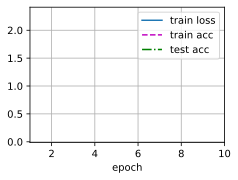

In [14]:
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
train_dataloader, test_dataloader = data.get_dataloader(train=True), data.get_dataloader(train=False)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
d2l.train_ch6(model, train_dataloader, test_dataloader, 10, 0.01, device)

## NiN (2013)  
该模型基于 AlexNet 设计，提出的目的是为了减少模型的参数及训练浮点需求。  
1. 该模型通过 1*1 卷积 + ReLU 在通道上引入非线性；
2. 模型输出的时候在单个通道的所有像素上使用全局池化以输出类别概率向量。  如果没有添加非线性，全局平均池化将不会有效

3. 最后一层使用全局池化代替 FC : 将所有数据压缩为1以提供正则化防止过拟合，泛化性好但是收敛速度慢，训练时间增长。

In [16]:
def nin_block(out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.LazyConv2d(out_channels, kernel_size, strides, padding), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU())

In [17]:
class NiN(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nin_block(96, kernel_size=11, strides=4, padding=0),
            nn.MaxPool2d(3, stride=2),
            nin_block(256, kernel_size=5, strides=1, padding=2),
            nn.MaxPool2d(3, stride=2),
            nin_block(384, kernel_size=3, strides=1, padding=1),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(0.5),
            nin_block(num_classes, kernel_size=3, strides=1, padding=1),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten())
        self.net.apply(d2l.init_cnn)

nn.AdaptiveAvgPool2d 会根据给定的输出尺寸，自动调整输入张量的池化区域，以便输出张量具有指定的高度和宽度。与固定的池化操作（如 nn.AvgPool2d）不同，nn.AdaptiveAvgPool2d 不需要指定池化的内核大小、步幅或填充，而是直接指定目标输出的尺寸。

In [18]:
NiN().layer_summary((1, 1, 224, 224))

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


## GoogLeNet
该模型融合前面三种模型的idea，利用不同卷积核大小提取不同感受野的信息（1 * 1， 3 * 3， 5 * 5），并将这些信息分布在不同数量的通道上，最后通过叠加这些信息以预测输出。 在特征提取结束的时候使用全局池化将特征数量压缩为 B * C * 1 * 1。显著减少了模型的参数数量（通过减少全连接层）

<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202408111505952.png" width='1000px' >
</div>

中间两个分支还添加了一个 1* 1卷积输入以减少通道数（作为瓶颈层），从而降低模型的复杂度。第四个分支使用最大池化及 1* 1 卷积层来改变通道数。  
Inception 块的常用超参数是每层的输出通道数，即如何在不同大小的卷积之间分配通道数量。  
Inception 模块中的并行性有助于提高其计算速度。  

辅助分类器   
实际分类时使用三个分类器输出结果的加权平均和，且可以提供更大的梯度缓解梯度消失的问题。  
同时可以有正则化的效果  


<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202411251541218.png" width='1000px' >
</div>


GoogLeNet 相较 VGG 参数少，模型复杂度低，计算快。

<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202408161958694.png" width='600px' >
</div>

V3 中使用了 softlabel 论文的改进不一定只靠模型结构，**训练方式及参数选择**也会对最终性能造成影响。  
使用**交叉熵**类型作为模型损失函数的时候， 可以考虑使用 softlabel ，传统交叉熵由于其他 label 为0使得损失仅关注正确label对应值的大小，softlabel 使得模型不仅最大化正确label预测的分数，同时缩小错误label对应的分数。    
$$ y' = (1-\epsilon)*y + \epsilon*u \quad \quad \quad u 为符合某种分布的误差项   $$  
该方法仅针对交叉熵损失误差的改进。

In [39]:
class Inception(nn.Module):
    # c1--c4 are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Branch 1
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        # Branch 2
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
        # Branch 3
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)
        # Branch 4
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)

    def forward(self, x):
        b1 = F.relu(self.b1_1(x))
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
        b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))
        b4 = F.relu(self.b4_2(self.b4_1(x)))
        return torch.cat((b1, b2, b3, b4), dim=1)

<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202408111507588.png" width='1000px' >
</div>



每个Inception块的各尺度通道数及中间压缩层（1 * 1）的通道数均为超参数，需要实验

In [40]:
class GoogleNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super(GoogleNet, self).__init__()
        self.save_hyperparameters()
        # 第一部分卷积层 用于数据消化。
        self.b1 = nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        
        self.b2 = nn.Sequential(nn.LazyConv2d(64, kernel_size=1), nn.ReLU(),
                    nn.LazyConv2d(192, kernel_size=3, padding=1), nn.ReLU(),
                    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

        #  第二 第三分支的中间降维卷积核 1*1 通道数为超参数，按照一定缩放比例设定。
        #  总体看 3*3 提取特征的通道数最多
        self.b3 = nn.Sequential(Inception(64, (96, 128), (16, 32), 32),
                         Inception(128, (128, 192), (32, 96), 64),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

        self.b4 = nn.Sequential(Inception(192, (96, 208), (16, 48), 64),
                         Inception(160, (112, 224), (24, 64), 64),
                         Inception(128, (128, 256), (24, 64), 64),
                         Inception(112, (144, 288), (32, 64), 64),
                         Inception(256, (160, 320), (32, 128), 128),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
                        
        self.b5 = nn.Sequential(Inception(256, (160, 320), (32, 128), 128),
                         Inception(384, (192, 384), (48, 128), 128),
                         nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())

        self.net = nn.Sequential(self.b1, self.b2, self.b3, self.b4,
                             self.b5, nn.LazyLinear(num_classes))

        self.net.apply(d2l.init_cnn)

In [45]:
model = GoogleNet().layer_summary((1, 1, 64, 64))


Sequential output shape:	 torch.Size([1, 64, 16, 16])
Sequential output shape:	 torch.Size([1, 192, 8, 8])
Sequential output shape:	 torch.Size([1, 480, 4, 4])
Sequential output shape:	 torch.Size([1, 832, 2, 2])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


training on cuda


KeyboardInterrupt: 

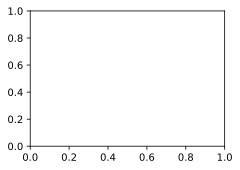

In [43]:
model = GoogleNet()
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
train_dataloader, test_dataloader = data.get_dataloader(train=True), data.get_dataloader(train=False)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
d2l.train_ch6(model, train_dataloader, test_dataloader, 10, 0.01, device)

GoogLeNet 优化方向：  
添加批量标准化层（Ioffe and Szegedy，2015），如后面第 8.5 节所述。

对 Inception 块进行调整（宽度、卷积的选择和顺序），如 Szegedy等人（2016）所述。

使用标签平滑进行模型正则化，如Szegedy等人（2016 年）所述 。

通过添加残差连接（Szegedy等，2017）对 Inception 块进行进一步调整，如后面第 8.6 节所述。  

Xception (2017)

## ResNet 
通过让网络可以习得恒等转换，使神经网络的能力随着深度的增加可以离目标函数更近。  
<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202408111920333.png" width='700px' >
</div>

resnet block  
<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202408111922966.png" width='500px' >
</div>   
Resnet - 18
<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202408111923133.png" width='800px' >
</div>   

ResNeXt  
添加分组卷积功能，减少计算复杂度

In [51]:
class Residual(nn.Module):  #@save
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [54]:
class ResNet(d2l.Classifier):

    def block(self, num_residuals, num_channels, first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                blk.append(Residual(num_channels))
        return nn.Sequential(*blk)

    def __init__(self, arch, lr=0.1, num_classes=10):
        super(ResNet, self).__init__()
        self.save_hyperparameters()
        self.b1 = nn.Sequential(
                nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
                nn.LazyBatchNorm2d(), nn.ReLU(),
                nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        self.net = nn.Sequential(self.b1)
        for i, b in enumerate(arch):
            self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
        self.net.add_module('last', nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
            nn.LazyLinear(num_classes)))
        self.net.apply(d2l.init_cnn)

    

In [55]:
class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                       lr, num_classes)

ResNet18().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 128, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 6, 6])
Sequential output shape:	 torch.Size([1, 512, 3, 3])
Sequential output shape:	 torch.Size([1, 10])


d:\Anaconda3\envs\data_torch\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### ResNeXt
**分组卷积**

In [ ]:
class ResNeXtBlock(nn.Module):  #@save
    """The ResNeXt block."""
    def __init__(self, num_channels, groups, bot_mul, use_1x1conv=False,
                 strides=1):
        super().__init__()
        bot_channels = int(round(num_channels * bot_mul))
        self.conv1 = nn.LazyConv2d(bot_channels, kernel_size=1, stride=1)
        self.conv2 = nn.LazyConv2d(bot_channels, kernel_size=3,
                                   stride=strides, padding=1,
                                   groups=bot_channels//groups)
        self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=1)
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()
        self.bn3 = nn.LazyBatchNorm2d()
        if use_1x1conv:
            self.conv4 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
            self.bn4 = nn.LazyBatchNorm2d()
        else:
            self.conv4 = None

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = F.relu(self.bn2(self.conv2(Y)))
        Y = self.bn3(self.conv3(Y))
        if self.conv4:
            X = self.bn4(self.conv4(X))
        return F.relu(Y + X)

## DenseNet

ResNet 仅使用了1阶残差信息， 受泰勒展开启发，可以利用更高阶的特征。  
因此可以将之前的输入与当前 block 的输出拼接，作为下一个 block 的输入。  

<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202408112014312.png" width='800px' >
</div>   

DenseNet 由**密集块** 与 **过渡层**构成， 密集块实现多阶信息利用，过渡层实现通道数及计算复杂度控制。




In [56]:
#  BN + RelU + 卷积 的卷积层实现
def conv_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=3, padding=1))

In [59]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # 将块的输入与输出连续拼接
            X = torch.cat((X, Y), dim=1)
        return X

#  转换块
def transition_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

In [62]:
class DenseNet(d2l.Classifier):
    def __init__(self, num_channels=64, growth_rate=32, arch=(4, 4, 4, 4),
             lr=0.1, num_classes=10):
        #  增长率用于计算通过密集块后，通道数增加多少，为密集块中的卷积数 * growth_rate
        super(DenseNet, self).__init__()
        self.save_hyperparameters()

        # 与 ResNet 首层相同
        self.b1 = nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

        self.net = nn.Sequential(self.b1)
        for i, num_convs in enumerate(arch):
            self.net.add_module(f'dense_blk{i+1}', DenseBlock(num_convs,
                                                            growth_rate))
            # The number of output channels in the previous dense block
            num_channels += num_convs * growth_rate
            # A transition layer that halves the number of channels is added
            # between the dense blocks
            if i != len(arch) - 1:
                num_channels //= 2
                self.net.add_module(f'tran_blk{i+1}', transition_block(
                    num_channels))
        self.net.add_module('last', nn.Sequential(
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
            nn.LazyLinear(num_classes)))
        self.net.apply(d2l.init_cnn)


In [63]:
DenseNet().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
DenseBlock output shape:	 torch.Size([1, 192, 24, 24])
Sequential output shape:	 torch.Size([1, 96, 12, 12])
DenseBlock output shape:	 torch.Size([1, 224, 12, 12])
Sequential output shape:	 torch.Size([1, 112, 6, 6])
DenseBlock output shape:	 torch.Size([1, 240, 6, 6])
Sequential output shape:	 torch.Size([1, 120, 3, 3])
DenseBlock output shape:	 torch.Size([1, 248, 3, 3])
Sequential output shape:	 torch.Size([1, 10])


## AnyNet 设计理念

网络由主干、主体 和头部 （stem, a body and a head） 组成。  
主干执行初始图像处理，通常通过具有较大窗口大小的卷积。  
主体由多个块组成，执行从原始图像到对象表示所需的大部分转换。主体又由多个阶段组成，以降低的分辨率对图像进行操作。  
最后，头部将其转换为所需的输出，例如通过多类分类的 softmax 回归器。  

网络架构
<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202408120952151.png" width='800px' >
</div> 

Body中每个 stage 将分辨率减半，通道数C0 - C4， 每个stage 的深度 di 及 bottleneck 比例 ki （即 bottleneck 通道数为ci/ki）也是超参数，还有每个stage的分组数（这个在每个stage中都相同）  
共17个超参数  
[AnyNet](!https://d2l.ai/chapter_convolutional-modern/cnn-design.html)  原始论文中对以上参数进行实验，可以查看原始论文，结果如下：  
ki，gi 在整个模型中可以保持一致，对性能没有影响。  ci，di需要根据顺序变大。  

<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202408121104029.png" width='800px' >
</div> 

In [3]:
class AnyNet(d2l.Classifier):
    def stem(self, num_channels):
        return nn.Sequential(
            nn.LazyConv2d(num_channels, kernel_size=3, stride=2, padding=1),
            nn.LazyBatchNorm2d(), nn.ReLU())
    
    def stage(self, depth, num_channels, groups, bot_mul):
        blk = []
        for i in range(depth):
            if i == 0:
                blk.append(d2l.ResNeXtBlock(num_channels, groups, bot_mul,
                    use_1x1conv=True, strides=2))
            else:
                blk.append(d2l.ResNeXtBlock(num_channels, groups, bot_mul))
        return nn.Sequential(*blk)

    def __init__(self, arch, stem_channels, lr=0.1, num_classes=10):
        super(AnyNet, self).__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(self.stem(stem_channels))
        for i, s in enumerate(arch):
            self.net.add_module(f'stage{i+1}', self.stage(*s))
        self.net.add_module('head', nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
            nn.LazyLinear(num_classes)))
        self.net.apply(d2l.init_cnn)    

In [5]:
#  从AnyNet 定义RegNet32
class RegNetX32(AnyNet):
    def __init__(self, lr=0.1, num_classes=10):
        stem_channels, groups, bot_mul = 32, 16, 1
        depths, channels = (4, 6), (32, 80)
        super().__init__(
            ((depths[0], channels[0], groups, bot_mul),
             (depths[1], channels[1], groups, bot_mul)),
            stem_channels, lr, num_classes)

In [6]:
RegNetX32().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 32, 48, 48])
Sequential output shape:	 torch.Size([1, 32, 24, 24])
Sequential output shape:	 torch.Size([1, 80, 12, 12])
Sequential output shape:	 torch.Size([1, 10])


d:\Anaconda3\envs\data_torch\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


loss 0.247, train acc 0.912, test acc 0.876
1924.1 examples/sec on cuda


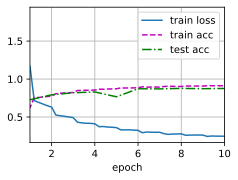

In [7]:
model = RegNetX32()
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
train_dataloader, test_dataloader = data.get_dataloader(train=True), data.get_dataloader(train=False)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
d2l.train_ch6(model, train_dataloader, test_dataloader, 10, 0.01, device)

``` python
class VioNet(AnyNet):
    def __init__(self, lr=0.1, num_classes=10, depths=(4, 6), channels=(32, 80),
                 stem_channels=32, groups=(16, 16), bot_mul=(1, 1)):
        super().__init__(
            [(depths[i], channels[i], groups[i], bot_mul[i]) for i in range(len(depths))],
            stem_channels, lr, num_classes)

VioNet_d = VioNet(depths=(6, 4))
VioNet_c = VioNet(channels=(80, 32))
VioNet_g = VioNet(groups=(16, 32))
VioNet_b = VioNet(bot_mul=(1, 2))
```
测试4类参数中哪种比较重要  

## MoblieNet

## 各种卷积操作

卷积底层优化计算： 将计算涉及的原始数据区域重新组合为一个矩阵，使用矩阵乘法计算最终输出结果。  
<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202411251945432.png" width='800px' >
</div>   

多通道卷积底层实现方式  同样将输入数据涉及的计算区域重新组合为一个矩阵，方便矩阵运算。
<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202411251948972.png" width='800px' >
</div> 

### 1. 空间可分离卷积  
减少计算复杂度  

<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202411251642764.png" width='800px' >
</div> 



### 2. 深度可分离卷积  
减少复杂度，先逐通道卷积再使用 1 * 1 卷积核控制输出通道  

### 3. 3D 卷积
通道方向上也可以卷积，即卷积核在 通道方向的尺寸 小于 数据通道 的尺寸。最终计算结果的通道数 = 数据通道数 // 卷积核通道数

### 4. 膨胀卷积 (空洞卷积)  
在不增加计算复杂度的条件下增加 感受野， 例如使用3 * 3 的卷积核一次获得 5 * 5 的感受野。  
实际上就是隔几个像素计算卷积  
适合处理信息密度较低的场景

### h - swish
hard 函数是对传统激活函数的近似，减少计算量，增加移动段的计算性能。  
  
<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202411251928687.png" height= '350px' width='600px' >
</div> 

## 经验tips

1. 中间层数据 通道维度 比较低的时候， 使用 ReLU 等激活函数会降低模型效果。  
  
<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202411251918182.png" width='800px' >
</div> 